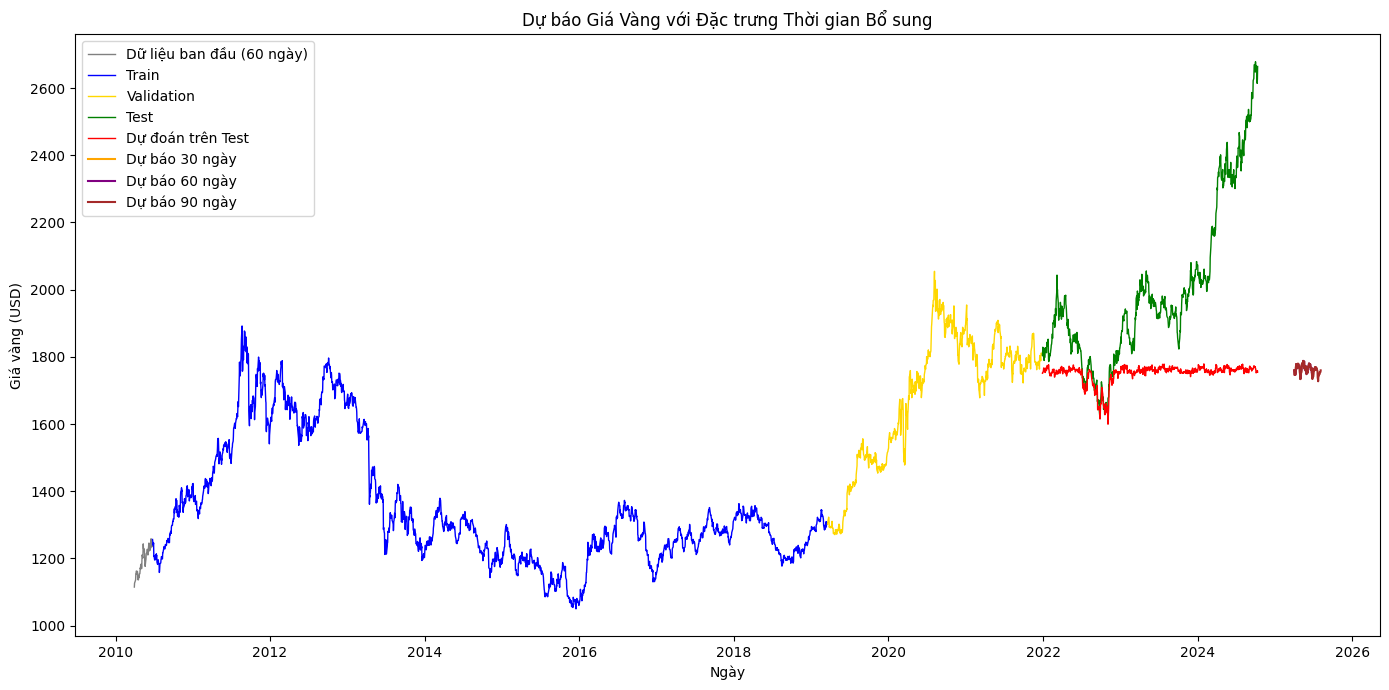

MAE: 246.96, MAPE: 11.29%, RMSE: 335.72, R²: -0.9572, Adjusted R²: -23.6195


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from xgboost import XGBRegressor
import os
import warnings
warnings.filterwarnings('ignore')

# 1. Đọc và xử lý dữ liệu
base_path = 'E:/PHAN TICH DU LIEU KINH DOANH/Do an/Splits'
train_df = pd.read_csv(os.path.join(base_path, 'train_60_20_20.csv'))
val_df = pd.read_csv(os.path.join(base_path, 'val_60_20_20.csv'))
test_df = pd.read_csv(os.path.join(base_path, 'test_60_20_20.csv'))

full_df = pd.concat([train_df, val_df, test_df], ignore_index=True)
full_df['Date'] = pd.to_datetime(full_df['Date'])
for col in ['Price', 'Open', 'High', 'Low']:
    full_df[col] = full_df[col].str.replace(',', '').astype(float)
full_df['Change %'] = full_df['Change %'].str.replace('%', '').astype(float)

def parse_volume(val):
    if isinstance(val, str):
        if val.endswith('K'):
            return float(val[:-1]) * 1e3
        elif val.endswith('M'):
            return float(val[:-1]) * 1e6
        else:
            return float(val)
    return np.nan

full_df['Vol.'] = full_df['Vol.'].apply(parse_volume)

# --- Tạo đặc trưng thời gian bổ sung ---
full_df['dayofweek'] = full_df['Date'].dt.dayofweek
full_df['month'] = full_df['Date'].dt.month
full_df['quarter'] = full_df['Date'].dt.quarter
full_df['year'] = full_df['Date'].dt.year

full_df = full_df.dropna().sort_values('Date').reset_index(drop=True)

# 2. Chuẩn hóa và tạo sliding window
features = ['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %', 'CPIAUCSL', 'dayofweek', 'month', 'quarter', 'year']
scaler = StandardScaler()
scaled_data = scaler.fit_transform(full_df[features])

timestep = 60
X, y = [], []
for i in range(timestep, len(scaled_data)):
    X.append(scaled_data[i - timestep:i].flatten())
    y.append(scaled_data[i, 0])  # target là Price chuẩn hóa
X, y = np.array(X), np.array(y)

n_train = len(train_df) - timestep
n_val = len(val_df) - timestep
n_test = len(test_df) - timestep

X_train = X[:n_train]
y_train = y[:n_train]
X_val = X[n_train:n_train + n_val]
y_val = y[n_train:n_train + n_val]
X_test = X[n_train + n_val:n_train + n_val + n_test]
y_test = y[n_train + n_val:n_train + n_val + n_test]

date_full = full_df['Date'].values
date_for_plot = date_full[timestep:]

# 3. Tối ưu tham số XGBoost (giữ nguyên hoặc thêm tuning như bạn muốn)
model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

# 4. Hàm hồi quy ngược
def inverse_scale(y_scaled):
    zeros_pad = np.zeros((len(y_scaled), len(features) - 1))
    y_scaled_full = np.hstack([y_scaled.reshape(-1,1), zeros_pad])
    return scaler.inverse_transform(y_scaled_full)[:, 0]

# 5. Dự báo multi-step với cập nhật đặc trưng thời gian
def forecast_future_with_time(model, last_sequence, n_days, scaler, timestep, n_features, last_date):
    preds = []
    current_seq = last_sequence.copy()
    current_date = last_date
    for _ in range(n_days):
        pred_scaled = model.predict(current_seq.flatten().reshape(1, -1))[0]
        preds.append(pred_scaled)
        current_seq = np.roll(current_seq, -1, axis=0)
        current_seq[-1, 0] = pred_scaled
        # Cập nhật time features cho ngày mới
        current_date += pd.Timedelta(days=1)
        current_seq[-1, -4] = current_date.dayofweek
        current_seq[-1, -3] = current_date.month
        current_seq[-1, -2] = (current_date.month - 1) // 3 + 1
        current_seq[-1, -1] = current_date.year
    preds_orig = inverse_scale(np.array(preds))
    return preds_orig

last_seq = scaled_data[-timestep:]
last_date = full_df['Date'].iloc[-1]

forecast_30 = forecast_future_with_time(model, last_seq, 30, scaler, timestep, len(features), last_date)
forecast_60 = forecast_future_with_time(model, last_seq, 60, scaler, timestep, len(features), last_date)
forecast_90 = forecast_future_with_time(model, last_seq, 90, scaler, timestep, len(features), last_date)

# 6. Dự báo trên test và hồi quy ngược
y_pred = model.predict(X_test)
y_test_orig = inverse_scale(y_test)
y_pred_orig = inverse_scale(y_pred)

# 7. Vẽ biểu đồ
plt.figure(figsize=(14, 7))
plt.plot(date_for_plot[:timestep], inverse_scale(y[:timestep]), color='gray', label='Dữ liệu ban đầu (60 ngày)', linewidth=1)
plt.plot(date_for_plot[timestep:n_train], inverse_scale(y[timestep:n_train]), color='blue', label='Train', linewidth=1)
plt.plot(date_for_plot[n_train:n_train+n_val], inverse_scale(y[n_train:n_train+n_val]), color='gold', label='Validation', linewidth=1)
plt.plot(date_for_plot[n_train+n_val:n_train+n_val+n_test], inverse_scale(y[n_train+n_val:n_train+n_val+n_test]), color='green', label='Test', linewidth=1)
plt.plot(date_for_plot[n_train+n_val:n_train+n_val+n_test], y_pred_orig, color='red', label='Dự đoán trên Test', linewidth=1)

future_dates = pd.date_range(date_full[-1] + pd.Timedelta(days=1), periods=90, freq='B')
plt.plot(future_dates[:30], forecast_30, color='orange', label='Dự báo 30 ngày', linewidth=1.5)
plt.plot(future_dates[:60], forecast_60, color='purple', label='Dự báo 60 ngày', linewidth=1.5)
plt.plot(future_dates[:90], forecast_90, color='brown', label='Dự báo 90 ngày', linewidth=1.5)

plt.title('Dự báo Giá Vàng với Đặc trưng Thời gian Bổ sung')
plt.xlabel('Ngày')
plt.ylabel('Giá vàng (USD)')
plt.legend()
plt.tight_layout()
plt.show()

# 8. In các chỉ số đánh giá
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test_orig, y_pred_orig)
mape = np.mean(np.abs((y_test_orig - y_pred_orig) / y_test_orig)) * 100
rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
r2 = r2_score(y_test_orig, y_pred_orig)
adjusted_r2 = 1 - (1 - r2) * (len(y_test_orig) - 1) / (len(y_test_orig) - X_test.shape[1] - 1)

print(f"MAE: {mae:.2f}, MAPE: {mape:.2f}%, RMSE: {rmse:.2f}, R²: {r2:.4f}, Adjusted R²: {adjusted_r2:.4f}")


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best params: {'subsample': 0.8, 'reg_lambda': 3, 'reg_alpha': 0.01, 'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 0.2, 'colsample_bytree': 0.9}


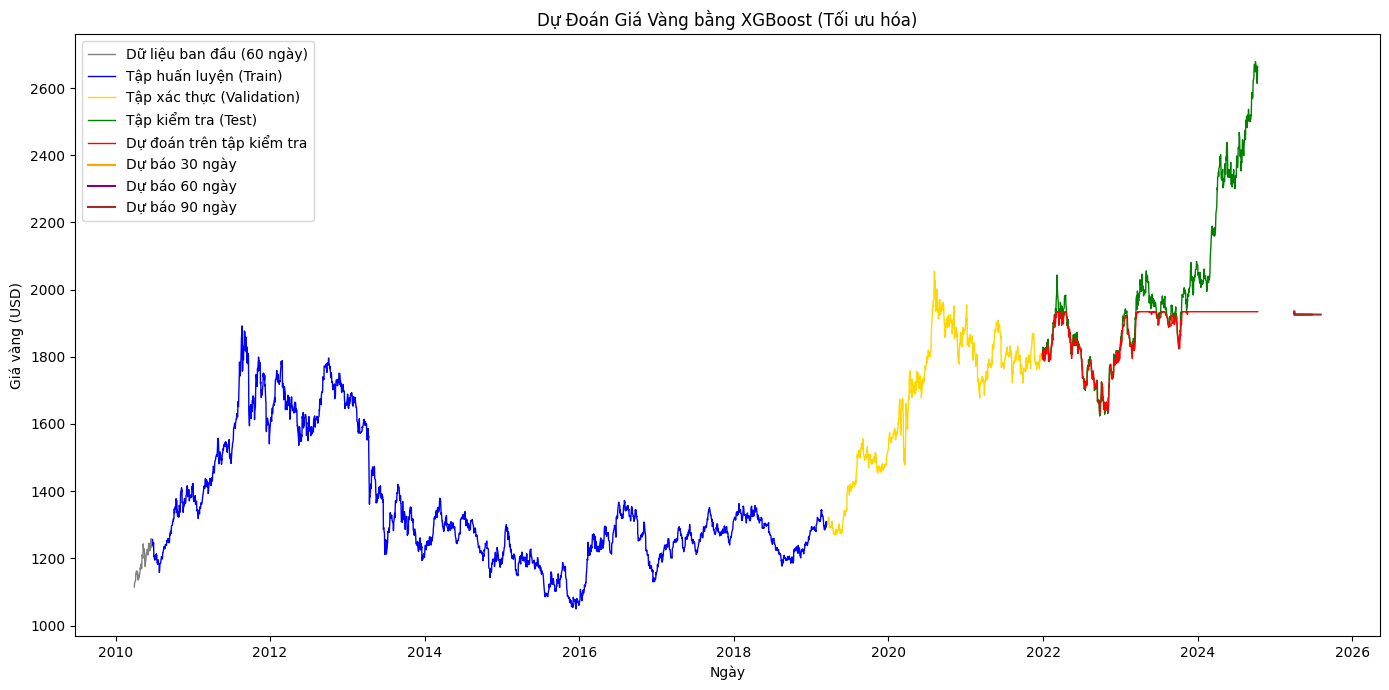

MAE: 126.33, MAPE: 5.46%, RMSE: 228.01, R²: 0.0972, Adjusted R²: -1.1795


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from xgboost import XGBRegressor
import os
import warnings
warnings.filterwarnings('ignore')

# ======== 1. Đọc và xử lý dữ liệu gốc ========
base_path = 'E:/PHAN TICH DU LIEU KINH DOANH/Do an/Splits'
train_df = pd.read_csv(os.path.join(base_path, 'train_60_20_20.csv'))
val_df = pd.read_csv(os.path.join(base_path, 'val_60_20_20.csv'))
test_df = pd.read_csv(os.path.join(base_path, 'test_60_20_20.csv'))

# Gộp dữ liệu để chuẩn hóa
full_df = pd.concat([train_df, val_df, test_df], ignore_index=True)
full_df['Date'] = pd.to_datetime(full_df['Date'])
for col in ['Price', 'Open', 'High', 'Low']:
    full_df[col] = full_df[col].str.replace(',', '').astype(float)
full_df['Change %'] = full_df['Change %'].str.replace('%', '').astype(float)

def parse_volume(val):
    if isinstance(val, str):
        if val.endswith('K'):
            return float(val[:-1]) * 1e3
        elif val.endswith('M'):
            return float(val[:-1]) * 1e6
        else:
            return float(val)
    return np.nan

full_df['Vol.'] = full_df['Vol.'].apply(parse_volume)
full_df = full_df.dropna().sort_values('Date').reset_index(drop=True)

# ======== 2. Chuẩn hóa và tạo sliding window ========
features = ['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %', 'CPIAUCSL']
scaler = StandardScaler()

# Thử log-transform giá vàng (nếu muốn, bỏ comment 2 dòng dưới)
# full_df['Price'] = np.log(full_df['Price'])
# (Sau khi dự báo xong, dùng np.exp() để hồi quy ngược)

scaled_data = scaler.fit_transform(full_df[features])

# Thử giảm sliding window xuống 60 (hoặc 30) thay vì 90
timestep = 60
X, y = [], []
for i in range(timestep, len(scaled_data)):
    X.append(scaled_data[i - timestep:i].flatten())
    y.append(scaled_data[i, 0])
X, y = np.array(X), np.array(y)

n_train = len(train_df) - timestep
n_val = len(val_df) - timestep
n_test = len(test_df) - timestep

X_train = X[:n_train]
y_train = y[:n_train]
X_val = X[n_train:n_train + n_val]
y_val = y[n_train:n_train + n_val]
X_test = X[n_train + n_val:n_train + n_val + n_test]
y_test = y[n_train + n_val:n_train + n_val + n_test]

date_full = full_df['Date'].values
date_for_plot = date_full[timestep:]

# ======== 3. Tối ưu tham số XGBoost bằng RandomizedSearchCV ========
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.01, 0.1, 1],
    'reg_lambda': [1, 1.5, 2, 3]
}

xgb = XGBRegressor(random_state=42, objective='reg:squarederror')
tscv = TimeSeriesSplit(n_splits=3)
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=20,
    scoring='neg_root_mean_squared_error',
    cv=tscv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Dùng train+val để tối ưu tham số
X_trainval = np.vstack([X_train, X_val])
y_trainval = np.hstack([y_train, y_val])

random_search.fit(X_trainval, y_trainval)
best_model = random_search.best_estimator_
print("Best params:", random_search.best_params_)

# ======== 4. Dự báo trên tập test ========
y_pred = best_model.predict(X_test)

def inverse_scale(y_scaled):
    return scaler.inverse_transform(np.concatenate([y_scaled.reshape(-1, 1), np.zeros((len(y_scaled), len(features) - 1))], axis=1))[:, 0]

y_test_orig = inverse_scale(y_test)
y_pred_orig = inverse_scale(y_pred)

# Nếu dùng log-transform, hồi quy ngược bằng np.exp()
# y_test_orig = np.exp(y_test_orig)
# y_pred_orig = np.exp(y_pred_orig)

# ======== 5. Dự báo multi-step 30/60/90 ngày ========
def forecast_future(model, last_sequence, n_days, scaler, timestep, n_features):
    predictions = []
    current_seq = last_sequence.copy()
    for _ in range(n_days):
        pred_scaled = model.predict(current_seq.flatten().reshape(1, -1))
        pred_orig = scaler.inverse_transform(
            np.concatenate([pred_scaled.reshape(-1, 1), np.zeros((1, n_features-1))], axis=1)
        )[0, 0]
        predictions.append(pred_orig)
        current_seq = np.roll(current_seq, -1, axis=0)
        current_seq[-1, 0] = pred_scaled
    return predictions

last_seq = scaled_data[-timestep:]
forecast_30 = forecast_future(best_model, last_seq, 30, scaler, timestep, len(features))
forecast_60 = forecast_future(best_model, last_seq, 60, scaler, timestep, len(features))
forecast_90 = forecast_future(best_model, last_seq, 90, scaler, timestep, len(features))

# ======== 6. Vẽ biểu đồ chuẩn khoa học dữ liệu ========
plt.figure(figsize=(14, 7))

plt.plot(date_for_plot[:timestep], inverse_scale(y[:timestep]), color='gray', label='Dữ liệu ban đầu (60 ngày)', linewidth=1)
plt.plot(date_for_plot[timestep:n_train], inverse_scale(y[timestep:n_train]), color='blue', label='Tập huấn luyện (Train)', linewidth=1)
plt.plot(date_for_plot[n_train:n_train+n_val], inverse_scale(y[n_train:n_train+n_val]), color='gold', label='Tập xác thực (Validation)', linewidth=1)
plt.plot(date_for_plot[n_train+n_val:n_train+n_val+n_test], inverse_scale(y[n_train+n_val:n_train+n_val+n_test]), color='green', label='Tập kiểm tra (Test)', linewidth=1)
plt.plot(date_for_plot[n_train+n_val:n_train+n_val+n_test], y_pred_orig, color='red', label='Dự đoán trên tập kiểm tra', linewidth=1)

# Multi-step forecast
future_dates = pd.date_range(date_full[-1] + pd.Timedelta(days=1), periods=90, freq='B')
plt.plot(future_dates[:30], forecast_30, color='orange', label='Dự báo 30 ngày', linewidth=1.5)
plt.plot(future_dates[:60], forecast_60, color='purple', label='Dự báo 60 ngày', linewidth=1.5)
plt.plot(future_dates[:90], forecast_90, color='brown', label='Dự báo 90 ngày', linewidth=1.5)

plt.title('Dự Đoán Giá Vàng bằng XGBoost')
plt.xlabel('Ngày')
plt.ylabel('Giá vàng (USD)')
plt.legend()
plt.tight_layout()
plt.show()

# ======== 7. In các thông số đánh giá ========
mae = mean_absolute_error(y_test_orig, y_pred_orig)
mape = np.mean(np.abs((y_test_orig - y_pred_orig) / y_test_orig)) * 100
rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
r2 = r2_score(y_test_orig, y_pred_orig)
adjusted_r2 = 1 - (1 - r2) * (len(y_test_orig) - 1) / (len(y_test_orig) - X_test.shape[1] - 1)

print(f"MAE: {mae:.2f}, MAPE: {mape:.2f}%, RMSE: {rmse:.2f}, R²: {r2:.4f}, Adjusted R²: {adjusted_r2:.4f}")
